In [1]:
# import and set options
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
import sklearn
from sklearn.metrics import roc_curve, auc
mpl.rcParams['pdf.fonttype'] = 42

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Clustering of cancer types

### Data processing 

The first step is to process the raw data to compute features used for clustering.

#### Read CHASM2 results

In [2]:
def read_result(cancer_type):
    mut_df = pd.read_table('data/aggregated_results/{0}.maf'.format(cancer_type))
    mut_df['UID'] = range(len(mut_df))
    useful_cols = ['UID', 'ID', 'CHASM2', 'CHASM2_genome', 'CHASM2_pval', 'CHASM2_genome_pval', 'CHASM2_qval', 'CHASM2_genome_qval']
    result_df = pd.read_table('data/aggregated_results/{0}.txt'.format(cancer_type), usecols=useful_cols)
    mut_cols = ['UID', 'Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short', 'CODE']
    result_df = pd.merge(result_df, mut_df[mut_cols], on='UID', how='left')
    result_df = result_df.rename(columns={'CHASM2_genome_qval': cancer_type})
    return result_df

In [3]:
cancer_types = [os.path.basename(f)[:-4] for f in glob.glob('data/aggregated_results/*.txt') if 'PANCAN' not in f]
merged_df = read_result('PANCAN')
for c in cancer_types:
    tmp = read_result(c)
    merged_df = pd.merge(merged_df, tmp[['Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short', c]],
                         on=['Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short'], how='left')

#### Merge with mutations in maf

In [4]:
# melt the data frame
merged2_df = pd.melt(merged_df, 
                     id_vars=['Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short'], value_vars=cancer_types+['PANCAN'],
                     var_name='CODE', value_name='qvalue')
merged2_df = merged2_df.dropna()
merged2_df['Protein_position'] = merged_df['HGVSp_Short'].str[3:-1]

In [5]:
# merge with 
mut_df = pd.read_table('data/aggregated_results/PANCAN.maf')
mut_df = pd.merge(mut_df, merged2_df, 
                  on=['Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short', 'CODE'],
                  how='left')

### Driver heterogeneity vs Prevalence Analysis

Examine the relationship between missense mutation driver prevalence and heterogeneity. Driver heterogeneity is measured by normalized entropy:

$$E = \frac{-\sum{p(i)\log_2{p(i)}}}{\log_2{k}}$$

where p(i) is the probability of a driver mutation being detected in the i'th codon, k is the total number of codons, and E represents the normalize entropy.

In [6]:
# calculate the normalized entropy among drivers
is_signif = mut_df['qvalue']<=.01
cts = mut_df[is_signif].groupby(['CODE', 'Hugo_Symbol', 'Transcript_ID', 'Protein_position_x']).size()
tot_muts = mut_df[is_signif].groupby(['CODE']).size()
frac_driver_missense = (cts / tot_muts).reset_index(name='fraction')
norm_ent = frac_driver_missense.groupby('CODE')['fraction'].apply(lambda x: -np.sum(x * np.log2(x))/ (np.log2(len(x)))).sort_values()

In [7]:
norm_ent.to_csv('data/normalized_driver_diversity.txt', sep='\t')

Prevalence is measured as the fraction of samples containing an identified driver mutation by CHASM2.

In [10]:
# calculate the fraction of samples containing an identified driver
mutated_samps = mut_df[is_signif].groupby(['CODE'])['Tumor_Sample_Barcode'].nunique()
total_samps = mut_df.groupby('CODE')['Tumor_Sample_Barcode'].nunique()
frac_mutated_samps = (mutated_samps / total_samps).reset_index(name='fraction of samples')

Examine how cancer types may cluster in terms of Driver heterogeneity/prevalence by using K-means. The number of clusters is selected by the maximum silhouette score.

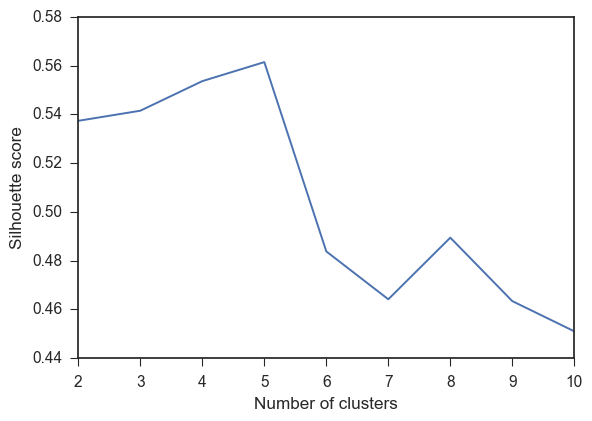

In [95]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# prepare the data
x = frac_mutated_samps.set_index('CODE')['fraction of samples']
y = norm_ent[frac_mutated_samps.CODE]
data = pd.DataFrame({'x': x, 'y': y })

# figure out the best number of clusters
possible_clusters = range(2, 11)
silhouete_scores = []
kmeans_models = []
for pc in possible_clusters:
    # fit kmeans
    km = KMeans(n_clusters=pc, random_state=101)
    fit = km.fit(data)
    # append score / model
    score = silhouette_score(data, fit.labels_)
    silhouete_scores.append(score)
    kmeans_models.append(fit)
    
# figure out the best clustering
max_ix = np.argmax(silhouete_scores)
best_model = kmeans_models[max_ix]
num_clusters = possible_clusters[max_ix]

# add cluster assignment
data['label'] = best_model.labels_

# plot the silhouette scores for various number of clusters
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.4):
    plt.plot(possible_clusters, silhouete_scores)
    plt.ylabel('Silhouette score')
    plt.xlabel('Number of clusters')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('left')
    #plt.savefig('figures/cluster_silhouette_score.pdf')

Now plot the clusters found through Kmeans

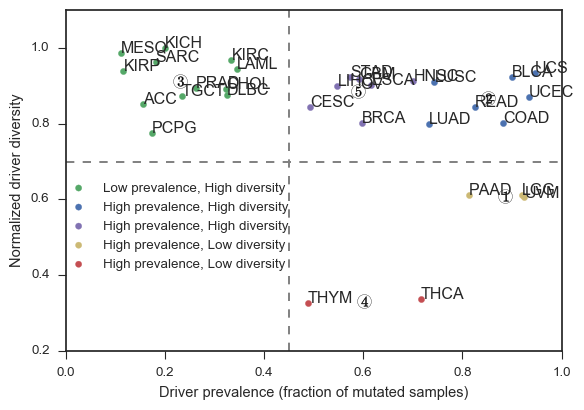

In [97]:
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.2):
    # data to plot
    cancer_types = data.index.tolist()
    
    # plot each cluster
    mypal = sns.color_palette()
    colors = [mypal[4], mypal[0], mypal[1], mypal[2], mypal[3]]
    for l in data['label'].unique():
        # get the cluster centers
        clust_center_x, clust_center_y = best_model.cluster_centers_[l, :]
        # figure out the label depending on where the cluster is
        if clust_center_x<.45 and clust_center_y>.7: label = 'Low prevalence, High diversity'
        elif clust_center_x>.45 and clust_center_y>.7: label = 'High prevalence, High diversity'
        elif clust_center_x>.45 and clust_center_y<.7: label = 'High prevalence, Low diversity'
        # plot the data
        plt.scatter(data.loc[data['label']==l, 'x'], data.loc[data['label']==l, 'y'], color=colors[l], label=label)
        # plot the kmeans centroids
        plt.scatter(clust_center_x, clust_center_y,  marker='o',
                    c="white", alpha=1, s=100, edgecolor='k')
        plt.scatter(clust_center_x, clust_center_y, marker='${0}$'.format(l+1), alpha=1,
                    s=50, edgecolor='k', color='black')
    
    # add divider lines
    plt.axhline(.7, linestyle='--', color='gray')
    plt.axvline(.45, linestyle='--', color='gray')
    
    # label/format axes
    plt.xlabel('Driver prevalence (fraction of mutated samples)')
    plt.ylabel('Normalized driver diversity')
    #plt.xlabel('Normalized entropy')
    #plt.ylabel('Simpson eveness')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('left')
    
    # add text
    for i, c in enumerate(cancer_types):
        plt.annotate(c, (x.iloc[i], y.iloc[i]))
        
    # add legend
    plt.legend(loc='lower left', bbox_to_anchor=(-0.025, .2))
    #plt.savefig('figures/driver_diversity_vs_prevalence.pdf')